## Imports

In [1]:
!pip install open3d

In [10]:
import os
import random
from random import randrange
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets import PartDataset
#from pointnet import PointNetCls
import torch.nn.functional as F
import matplotlib.pyplot as plt
import open3d as o3
#import download
from open3d import JVisualizer
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

# Dataset

We are going to work with the ShapeNet Dataset.
It's coming from Standford and will allow us to do both Classification and Segmentation.

In [11]:
#Run this only if you don't already have the Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

  Issued certificate has expired.
2021-02-16 11:45:10 URL:https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip [666265910/666265910] -> "shapenetcore_partanno_segmentation_benchmark_v0.zip" [1]
Archive:  shapenetcore_partanno_segmentation_benchmark_v0.zip
replace shapenetcore_partanno_segmentation_benchmark_v0/02954340/seg_img/e823673c1edd73fb97c426435543a860.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = DATA_FOLDER = './shapenetcore_partanno_segmentation_benchmark_v0'


In [2]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
import json
import codecs
import numpy as np
import progressbar
import sys
import torchvision.transforms as transforms
import argparse
import json
import open3d


class PartDataset(data.Dataset):
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}

        self.classification = classification

        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}

        self.meta = {}
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            #print(dir_point, dir_seg)
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns:
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg')))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1]))


        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        print(self.classes)
        self.num_seg_classes = 0
        if not self.classification:
            for i in range(len(self.datapath)//50):
                l = len(np.unique(np.loadtxt(self.datapath[i][-1]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)


    def __getitem__(self, index):
        fn = self.datapath[index]
        cls = self.classes[self.datapath[index][0]]
        point_set = np.asarray(
            open3d.io.read_point_cloud(fn[1], format='xyz').points,
            dtype=np.float32)
        seg = np.loadtxt(fn[2]).astype(np.int64)
        #print(point_set.shape, seg.shape)

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        #resample
        point_set = point_set[choice, :]
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        if self.classification:
            return point_set, cls
        else:
            return point_set, seg

    def __len__(self):
        return len(self.datapath)

test
{'Chair': 0}
3371
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
15990
torch.Size([2500, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor


In [6]:
# Create dataset object
test_dataset_seg = PartDataset(
    root=DATA_FOLDER,
    train=False,
    classification=False,
    npoints=NUM_POINTS)

# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}


## Visualize the Dataset with Open3D

In [28]:
d = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', class_choice = ['Airplane'])
print(len(d))
import random
ps, seg = random.choice(d)
print(ps.size(), ps.type(), seg.size(),seg.type())

'''
d = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True)
print(len(d))
ps, cls = d[0]
print(ps.size(), ps.type(), cls.size(),cls.type())
'''

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
15990
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor


"\nd = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True)\nprint(len(d))\nps, cls = d[0]\nprint(ps.size(), ps.type(), cls.size(),cls.type())\n"

In [17]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [29]:
test_vis = JVisualizer()
test_vis.clear()
clear_output()
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

test_vis.add_geometry(test_cloud)
test_vis.show()

JVisualizer with 1 geometries

# 3D Deep Learning Model

## Build the Model

In [36]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d()
out = trans(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


In [31]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        
    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [37]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


In [32]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1), trans

In [38]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


In [33]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans

In [39]:
seg = PointNetDenseCls(k = 3)
out, _ = seg(sim_data)
print('seg', out.size())

seg torch.Size([32, 2500, 3])


## Train the Model for classification and segmentation

In [50]:
batchSize = 32
num_points = 2500
workers = 4
nepoch = 25
outf="cls"

In [ ]:
# DATASET & DATA LOADER
dataset = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True, npoints = num_points)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

test_dataset = PartDataset(root = 'shapenetcore_partanno_segmentation_benchmark_v0', classification = True, train = False, npoints = num_points)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,shuffle=True, num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())
classifier = PointNetCls(k = num_classes, num_points = num_points)
#classifier.load_state_dict(torch.load(""))

# DEFINE OPTIMIZERS
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize

# TRAIN ON EPOCHS
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        points, target = data
        points, target = Variable(points), Variable(target[:,0])
        points = points.transpose(2,1)
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, _ = classifier(points)
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9, 'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 'Skateboard': 14, 'Table': 15}
[0: 0/499] train loss: 2.811898 accuracy: 0.031250
[0: 0/499] test loss: 2.758509 accuracy: 0.031250
[0: 1/499] train loss: 2.772773 accuracy: 0.156250
[0: 2/499] train loss: 2.092318 accuracy: 0.562500
[0: 3/499] train loss: 1.919288 accuracy: 0.625000
[0: 4/499] train loss: 1.464674 accuracy: 0.718750
[0: 5/499] train loss: 1.358144 accuracy: 0.718750
[0: 6/499] train loss: 0.945803 accuracy: 0.781250
[0: 7/499] train loss: 0.868699 accuracy: 0.812500
[0: 8/499] train loss: 0.473060 accuracy: 0.937500
[0: 9/499] train loss: 0.721222 accuracy: 0.843750
[0: 10/499] train loss

[0: 133/499] train loss: 0.346179 accuracy: 0.906250
[0: 134/499] train loss: 0.232819 accuracy: 0.875000
[0: 135/499] train loss: 0.543591 accuracy: 0.843750
[0: 136/499] train loss: 0.215936 accuracy: 0.968750
[0: 137/499] train loss: 0.358993 accuracy: 0.875000
[0: 138/499] train loss: 0.193040 accuracy: 0.937500
[0: 139/499] train loss: 0.257632 accuracy: 0.937500
[0: 140/499] train loss: 0.544990 accuracy: 0.875000
[0: 140/499] test loss: 0.351708 accuracy: 0.906250
[0: 141/499] train loss: 0.253314 accuracy: 0.906250
[0: 142/499] train loss: 0.280004 accuracy: 0.906250
[0: 143/499] train loss: 0.161924 accuracy: 0.937500
[0: 144/499] train loss: 0.143302 accuracy: 0.937500
[0: 145/499] train loss: 0.145386 accuracy: 0.937500
[0: 146/499] train loss: 0.111803 accuracy: 0.968750
[0: 147/499] train loss: 0.142283 accuracy: 0.906250
[0: 148/499] train loss: 0.148761 accuracy: 0.937500
[0: 149/499] train loss: 0.158908 accuracy: 0.937500
[0: 150/499] train loss: 0.325102 accuracy: 0.9

[0: 273/499] train loss: 0.067987 accuracy: 0.968750
[0: 274/499] train loss: 0.428172 accuracy: 0.906250
[0: 275/499] train loss: 0.116141 accuracy: 0.968750
[0: 276/499] train loss: 0.060413 accuracy: 1.000000
[0: 277/499] train loss: 0.150830 accuracy: 0.937500
[0: 278/499] train loss: 0.306433 accuracy: 0.906250
[0: 279/499] train loss: 0.200595 accuracy: 0.937500
[0: 280/499] train loss: 0.164518 accuracy: 0.968750
[0: 280/499] test loss: 0.011022 accuracy: 1.000000
[0: 281/499] train loss: 0.082950 accuracy: 0.968750
[0: 282/499] train loss: 0.047679 accuracy: 1.000000
[0: 283/499] train loss: 0.413928 accuracy: 0.937500
[0: 284/499] train loss: 0.203678 accuracy: 0.937500
[0: 285/499] train loss: 0.338821 accuracy: 0.906250
[0: 286/499] train loss: 0.145402 accuracy: 0.937500
[0: 287/499] train loss: 0.055277 accuracy: 1.000000
[0: 288/499] train loss: 0.085555 accuracy: 0.968750
[0: 289/499] train loss: 0.180971 accuracy: 0.937500
[0: 290/499] train loss: 0.143095 accuracy: 0.9

[0: 413/499] train loss: 0.147422 accuracy: 0.968750
[0: 414/499] train loss: 0.046533 accuracy: 1.000000
[0: 415/499] train loss: 0.016164 accuracy: 1.000000
[0: 416/499] train loss: 0.078253 accuracy: 0.968750
[0: 417/499] train loss: 0.118517 accuracy: 0.968750
[0: 418/499] train loss: 0.057643 accuracy: 1.000000
[0: 419/499] train loss: 0.119003 accuracy: 0.968750
[0: 420/499] train loss: 0.171383 accuracy: 0.968750
[0: 420/499] test loss: 0.172953 accuracy: 0.937500
[0: 421/499] train loss: 0.187723 accuracy: 0.968750
[0: 422/499] train loss: 0.013087 accuracy: 1.000000
[0: 423/499] train loss: 0.058339 accuracy: 0.968750
[0: 424/499] train loss: 0.123966 accuracy: 0.937500
[0: 425/499] train loss: 0.318372 accuracy: 0.875000
[0: 426/499] train loss: 0.317430 accuracy: 0.906250
[0: 427/499] train loss: 0.023243 accuracy: 1.000000
[0: 428/499] train loss: 0.146202 accuracy: 0.937500
[0: 429/499] train loss: 0.112238 accuracy: 0.968750
[0: 430/499] train loss: 0.087572 accuracy: 0.9

[1: 53/499] train loss: 0.117441 accuracy: 0.937500
[1: 54/499] train loss: 0.059869 accuracy: 1.000000
[1: 55/499] train loss: 0.165114 accuracy: 0.906250
[1: 56/499] train loss: 0.143854 accuracy: 0.968750
[1: 57/499] train loss: 0.113094 accuracy: 0.968750
[1: 58/499] train loss: 0.117285 accuracy: 0.906250
[1: 59/499] train loss: 0.406945 accuracy: 0.906250
[1: 60/499] train loss: 0.367496 accuracy: 0.906250
[1: 60/499] test loss: 0.037473 accuracy: 1.000000
[1: 61/499] train loss: 0.033197 accuracy: 1.000000
[1: 62/499] train loss: 0.099876 accuracy: 0.968750
[1: 63/499] train loss: 0.043841 accuracy: 1.000000
[1: 64/499] train loss: 0.089495 accuracy: 0.937500
[1: 65/499] train loss: 0.216835 accuracy: 0.937500
[1: 66/499] train loss: 0.079373 accuracy: 0.968750
[1: 67/499] train loss: 0.164501 accuracy: 0.906250
[1: 68/499] train loss: 0.052211 accuracy: 1.000000
[1: 69/499] train loss: 0.263049 accuracy: 0.937500
[1: 70/499] train loss: 0.076783 accuracy: 0.968750
[1: 70/499] t

[1: 193/499] train loss: 0.299942 accuracy: 0.937500
[1: 194/499] train loss: 0.008597 accuracy: 1.000000
[1: 195/499] train loss: 0.021445 accuracy: 1.000000
[1: 196/499] train loss: 0.014334 accuracy: 1.000000
[1: 197/499] train loss: 0.113955 accuracy: 0.937500
[1: 198/499] train loss: 0.041167 accuracy: 1.000000
[1: 199/499] train loss: 0.008771 accuracy: 1.000000
[1: 200/499] train loss: 0.247767 accuracy: 0.937500
[1: 200/499] test loss: 0.009690 accuracy: 1.000000
[1: 201/499] train loss: 0.270019 accuracy: 0.968750
[1: 202/499] train loss: 0.017780 accuracy: 1.000000
[1: 203/499] train loss: 0.060457 accuracy: 1.000000
[1: 204/499] train loss: 0.079282 accuracy: 0.968750
[1: 205/499] train loss: 0.085939 accuracy: 0.968750
[1: 206/499] train loss: 0.077855 accuracy: 1.000000
[1: 207/499] train loss: 0.149574 accuracy: 0.968750
[1: 208/499] train loss: 0.048617 accuracy: 1.000000
[1: 209/499] train loss: 0.004982 accuracy: 1.000000
[1: 210/499] train loss: 0.015323 accuracy: 1.0

[1: 333/499] train loss: 0.021256 accuracy: 1.000000
[1: 334/499] train loss: 0.012178 accuracy: 1.000000
[1: 335/499] train loss: 0.201873 accuracy: 0.968750
[1: 336/499] train loss: 0.008530 accuracy: 1.000000
[1: 337/499] train loss: 0.072169 accuracy: 0.968750
[1: 338/499] train loss: 0.085769 accuracy: 0.968750
[1: 339/499] train loss: 0.076084 accuracy: 0.968750
[1: 340/499] train loss: 0.010040 accuracy: 1.000000
[1: 340/499] test loss: 0.070744 accuracy: 0.968750
[1: 341/499] train loss: 0.012797 accuracy: 1.000000
[1: 342/499] train loss: 0.010062 accuracy: 1.000000
[1: 343/499] train loss: 0.229787 accuracy: 0.968750
[1: 344/499] train loss: 0.072550 accuracy: 0.968750
[1: 345/499] train loss: 0.079211 accuracy: 0.968750
[1: 346/499] train loss: 0.004344 accuracy: 1.000000
[1: 347/499] train loss: 0.235240 accuracy: 0.968750
[1: 348/499] train loss: 0.259329 accuracy: 0.937500
[1: 349/499] train loss: 0.151516 accuracy: 0.968750
[1: 350/499] train loss: 0.073106 accuracy: 0.9

[1: 473/499] train loss: 0.190584 accuracy: 0.937500
[1: 474/499] train loss: 0.013330 accuracy: 1.000000
[1: 475/499] train loss: 0.037681 accuracy: 1.000000
[1: 476/499] train loss: 0.007490 accuracy: 1.000000
[1: 477/499] train loss: 0.173532 accuracy: 0.968750
[1: 478/499] train loss: 0.037776 accuracy: 0.968750
[1: 479/499] train loss: 0.192840 accuracy: 0.968750
[1: 480/499] train loss: 0.044867 accuracy: 1.000000
[1: 480/499] test loss: 0.015281 accuracy: 1.000000
[1: 481/499] train loss: 0.061330 accuracy: 0.968750
[1: 482/499] train loss: 0.283926 accuracy: 0.937500
[1: 483/499] train loss: 0.012941 accuracy: 1.000000
[1: 484/499] train loss: 0.021630 accuracy: 1.000000
[1: 485/499] train loss: 0.198024 accuracy: 0.968750
[1: 486/499] train loss: 0.106737 accuracy: 0.968750
[1: 487/499] train loss: 0.005323 accuracy: 1.000000
[1: 488/499] train loss: 0.062450 accuracy: 0.968750
[1: 489/499] train loss: 0.026590 accuracy: 1.000000
[1: 490/499] train loss: 0.220621 accuracy: 0.9

[2: 116/499] train loss: 0.189671 accuracy: 0.937500
[2: 117/499] train loss: 0.096547 accuracy: 0.968750
[2: 118/499] train loss: 0.043595 accuracy: 1.000000
[2: 119/499] train loss: 0.009193 accuracy: 1.000000
[2: 120/499] train loss: 0.008084 accuracy: 1.000000
[2: 120/499] test loss: 0.062609 accuracy: 0.968750
[2: 121/499] train loss: 0.082172 accuracy: 0.937500
[2: 122/499] train loss: 0.016531 accuracy: 1.000000
[2: 123/499] train loss: 0.004022 accuracy: 1.000000
[2: 124/499] train loss: 0.016519 accuracy: 1.000000
[2: 125/499] train loss: 0.029524 accuracy: 1.000000
[2: 126/499] train loss: 0.129626 accuracy: 0.906250
[2: 127/499] train loss: 0.006367 accuracy: 1.000000
[2: 128/499] train loss: 0.019813 accuracy: 1.000000
[2: 129/499] train loss: 0.309739 accuracy: 0.968750
[2: 130/499] train loss: 0.075714 accuracy: 0.968750
[2: 130/499] test loss: 0.054208 accuracy: 0.968750
[2: 131/499] train loss: 0.325408 accuracy: 0.906250
[2: 132/499] train loss: 0.402460 accuracy: 0.93

[2: 256/499] train loss: 0.022920 accuracy: 1.000000
[2: 257/499] train loss: 0.007174 accuracy: 1.000000
[2: 258/499] train loss: 0.002816 accuracy: 1.000000
[2: 259/499] train loss: 0.015334 accuracy: 1.000000
[2: 260/499] train loss: 0.011442 accuracy: 1.000000
[2: 260/499] test loss: 0.009867 accuracy: 1.000000
[2: 261/499] train loss: 0.034115 accuracy: 1.000000
[2: 262/499] train loss: 0.113592 accuracy: 0.937500
[2: 263/499] train loss: 0.075659 accuracy: 0.968750
[2: 264/499] train loss: 0.224174 accuracy: 0.937500
[2: 265/499] train loss: 0.052393 accuracy: 1.000000
[2: 266/499] train loss: 0.017048 accuracy: 1.000000
[2: 267/499] train loss: 0.086504 accuracy: 0.937500
[2: 268/499] train loss: 0.017612 accuracy: 1.000000
[2: 269/499] train loss: 0.047118 accuracy: 0.968750
[2: 270/499] train loss: 0.313939 accuracy: 0.937500
[2: 270/499] test loss: 0.017975 accuracy: 1.000000
[2: 271/499] train loss: 0.072718 accuracy: 0.968750
[2: 272/499] train loss: 0.006166 accuracy: 1.00

[2: 396/499] train loss: 0.017563 accuracy: 1.000000
[2: 397/499] train loss: 0.064884 accuracy: 0.968750
[2: 398/499] train loss: 0.005127 accuracy: 1.000000
[2: 399/499] train loss: 0.016373 accuracy: 1.000000
[2: 400/499] train loss: 0.030572 accuracy: 1.000000
[2: 400/499] test loss: 0.212610 accuracy: 0.937500
[2: 401/499] train loss: 0.047370 accuracy: 0.968750
[2: 402/499] train loss: 0.006723 accuracy: 1.000000
[2: 403/499] train loss: 0.110173 accuracy: 0.937500
[2: 404/499] train loss: 0.067802 accuracy: 0.968750
[2: 405/499] train loss: 0.213218 accuracy: 0.968750
[2: 406/499] train loss: 0.047411 accuracy: 0.968750
[2: 407/499] train loss: 0.129844 accuracy: 0.937500
[2: 408/499] train loss: 0.163286 accuracy: 0.968750
[2: 409/499] train loss: 0.032275 accuracy: 0.968750
[2: 410/499] train loss: 0.004774 accuracy: 1.000000
[2: 410/499] test loss: 0.028727 accuracy: 1.000000
[2: 411/499] train loss: 0.163865 accuracy: 0.937500
[2: 412/499] train loss: 0.070214 accuracy: 0.96

[3: 36/499] train loss: 0.076421 accuracy: 0.968750
[3: 37/499] train loss: 0.036377 accuracy: 1.000000
[3: 38/499] train loss: 0.002511 accuracy: 1.000000
[3: 39/499] train loss: 0.026425 accuracy: 1.000000
[3: 40/499] train loss: 0.057353 accuracy: 0.968750
[3: 40/499] test loss: 0.020364 accuracy: 1.000000
[3: 41/499] train loss: 0.004445 accuracy: 1.000000
[3: 42/499] train loss: 0.031474 accuracy: 1.000000
[3: 43/499] train loss: 0.012078 accuracy: 1.000000
[3: 44/499] train loss: 0.185019 accuracy: 0.968750
[3: 45/499] train loss: 0.024148 accuracy: 1.000000
[3: 46/499] train loss: 0.006930 accuracy: 1.000000
[3: 47/499] train loss: 0.002817 accuracy: 1.000000
[3: 48/499] train loss: 0.027868 accuracy: 1.000000
[3: 49/499] train loss: 0.084099 accuracy: 0.968750
[3: 50/499] train loss: 0.048609 accuracy: 0.968750
[3: 50/499] test loss: 0.003686 accuracy: 1.000000
[3: 51/499] train loss: 0.216437 accuracy: 0.968750
[3: 52/499] train loss: 0.171664 accuracy: 0.937500
[3: 53/499] tr

[3: 176/499] train loss: 0.216785 accuracy: 0.937500
[3: 177/499] train loss: 0.306214 accuracy: 0.937500
[3: 178/499] train loss: 0.084647 accuracy: 0.968750
[3: 179/499] train loss: 0.103211 accuracy: 0.968750
[3: 180/499] train loss: 0.031926 accuracy: 1.000000
[3: 180/499] test loss: 0.063966 accuracy: 1.000000
[3: 181/499] train loss: 0.151166 accuracy: 0.968750
[3: 182/499] train loss: 0.269130 accuracy: 0.937500
[3: 183/499] train loss: 0.013545 accuracy: 1.000000
[3: 184/499] train loss: 0.061326 accuracy: 1.000000
[3: 185/499] train loss: 0.030270 accuracy: 1.000000
[3: 186/499] train loss: 0.087877 accuracy: 0.968750
[3: 187/499] train loss: 0.013522 accuracy: 1.000000
[3: 188/499] train loss: 0.115482 accuracy: 0.968750
[3: 189/499] train loss: 0.114950 accuracy: 0.968750
[3: 190/499] train loss: 0.075348 accuracy: 0.968750
[3: 190/499] test loss: 0.259936 accuracy: 0.937500
[3: 191/499] train loss: 0.122810 accuracy: 0.968750
[3: 192/499] train loss: 0.029800 accuracy: 1.00

[3: 316/499] train loss: 0.009818 accuracy: 1.000000
[3: 317/499] train loss: 0.280857 accuracy: 0.906250
[3: 318/499] train loss: 0.044324 accuracy: 1.000000
[3: 319/499] train loss: 0.019029 accuracy: 1.000000
[3: 320/499] train loss: 0.082230 accuracy: 0.968750
[3: 320/499] test loss: 0.006971 accuracy: 1.000000
[3: 321/499] train loss: 0.032369 accuracy: 1.000000
[3: 322/499] train loss: 0.205798 accuracy: 0.968750
[3: 323/499] train loss: 0.004152 accuracy: 1.000000
[3: 324/499] train loss: 0.065644 accuracy: 0.968750
[3: 325/499] train loss: 0.066195 accuracy: 0.968750
[3: 326/499] train loss: 0.036808 accuracy: 0.968750
[3: 327/499] train loss: 0.182962 accuracy: 0.906250
[3: 328/499] train loss: 0.071386 accuracy: 0.968750
[3: 329/499] train loss: 0.051726 accuracy: 1.000000
[3: 330/499] train loss: 0.054540 accuracy: 0.968750
[3: 330/499] test loss: 0.034316 accuracy: 0.968750
[3: 331/499] train loss: 0.024796 accuracy: 1.000000
[3: 332/499] train loss: 0.020301 accuracy: 1.00

[3: 456/499] train loss: 0.117443 accuracy: 0.968750
[3: 457/499] train loss: 0.003167 accuracy: 1.000000
[3: 458/499] train loss: 0.038414 accuracy: 1.000000
[3: 459/499] train loss: 0.001617 accuracy: 1.000000
[3: 460/499] train loss: 0.006132 accuracy: 1.000000
[3: 460/499] test loss: 0.005282 accuracy: 1.000000
[3: 461/499] train loss: 0.014431 accuracy: 1.000000
[3: 462/499] train loss: 0.022759 accuracy: 1.000000
[3: 463/499] train loss: 0.003015 accuracy: 1.000000
[3: 464/499] train loss: 0.056610 accuracy: 0.968750
[3: 465/499] train loss: 0.107906 accuracy: 0.968750
[3: 466/499] train loss: 0.007969 accuracy: 1.000000
[3: 467/499] train loss: 0.005918 accuracy: 1.000000
[3: 468/499] train loss: 0.047171 accuracy: 0.968750
[3: 469/499] train loss: 0.048946 accuracy: 1.000000
[3: 470/499] train loss: 0.018744 accuracy: 1.000000
[3: 470/499] test loss: 0.141818 accuracy: 0.968750
[3: 471/499] train loss: 0.030907 accuracy: 1.000000
[3: 472/499] train loss: 0.076394 accuracy: 0.93

[4: 99/499] train loss: 0.002273 accuracy: 1.000000
[4: 100/499] train loss: 0.013555 accuracy: 1.000000
[4: 100/499] test loss: 0.282943 accuracy: 0.968750
[4: 101/499] train loss: 0.042872 accuracy: 0.968750
[4: 102/499] train loss: 0.047628 accuracy: 0.968750
[4: 103/499] train loss: 0.030374 accuracy: 1.000000
[4: 104/499] train loss: 0.004378 accuracy: 1.000000
[4: 105/499] train loss: 0.015633 accuracy: 1.000000
[4: 106/499] train loss: 0.016277 accuracy: 1.000000
[4: 107/499] train loss: 0.002449 accuracy: 1.000000
[4: 108/499] train loss: 0.008578 accuracy: 1.000000
[4: 109/499] train loss: 0.055506 accuracy: 0.968750
[4: 110/499] train loss: 0.210211 accuracy: 0.937500
[4: 110/499] test loss: 0.005667 accuracy: 1.000000
[4: 111/499] train loss: 0.007336 accuracy: 1.000000
[4: 112/499] train loss: 0.103351 accuracy: 0.968750
[4: 113/499] train loss: 0.125592 accuracy: 0.968750
[4: 114/499] train loss: 0.008445 accuracy: 1.000000
[4: 115/499] train loss: 0.028813 accuracy: 1.000

[4: 239/499] train loss: 0.190411 accuracy: 0.968750
[4: 240/499] train loss: 0.343779 accuracy: 0.968750
[4: 240/499] test loss: 0.004221 accuracy: 1.000000
[4: 241/499] train loss: 0.014924 accuracy: 1.000000
[4: 242/499] train loss: 0.006874 accuracy: 1.000000
[4: 243/499] train loss: 0.008796 accuracy: 1.000000
[4: 244/499] train loss: 0.367722 accuracy: 0.937500
[4: 245/499] train loss: 0.007209 accuracy: 1.000000
[4: 246/499] train loss: 0.028985 accuracy: 1.000000
[4: 247/499] train loss: 0.007437 accuracy: 1.000000
[4: 248/499] train loss: 0.014103 accuracy: 1.000000
[4: 249/499] train loss: 0.009577 accuracy: 1.000000
[4: 250/499] train loss: 0.009713 accuracy: 1.000000
[4: 250/499] test loss: 0.012655 accuracy: 1.000000
[4: 251/499] train loss: 0.015486 accuracy: 1.000000
[4: 252/499] train loss: 0.009810 accuracy: 1.000000
[4: 253/499] train loss: 0.015300 accuracy: 1.000000
[4: 254/499] train loss: 0.157585 accuracy: 0.968750
[4: 255/499] train loss: 0.099155 accuracy: 0.96

[4: 379/499] train loss: 0.022366 accuracy: 1.000000
[4: 380/499] train loss: 0.050758 accuracy: 0.968750
[4: 380/499] test loss: 0.009244 accuracy: 1.000000
[4: 381/499] train loss: 0.054540 accuracy: 0.968750
[4: 382/499] train loss: 0.009658 accuracy: 1.000000
[4: 383/499] train loss: 0.003726 accuracy: 1.000000
[4: 384/499] train loss: 0.074756 accuracy: 0.968750
[4: 385/499] train loss: 0.029707 accuracy: 1.000000
[4: 386/499] train loss: 0.010080 accuracy: 1.000000
[4: 387/499] train loss: 0.002685 accuracy: 1.000000
[4: 388/499] train loss: 0.001472 accuracy: 1.000000
[4: 389/499] train loss: 0.063042 accuracy: 0.968750
[4: 390/499] train loss: 0.058618 accuracy: 0.968750
[4: 390/499] test loss: 0.001494 accuracy: 1.000000
[4: 391/499] train loss: 0.007328 accuracy: 1.000000
[4: 392/499] train loss: 0.006913 accuracy: 1.000000
[4: 393/499] train loss: 0.032952 accuracy: 0.968750
[4: 394/499] train loss: 0.001782 accuracy: 1.000000
[4: 395/499] train loss: 0.225761 accuracy: 0.93

[5: 19/499] train loss: 0.012311 accuracy: 1.000000
[5: 20/499] train loss: 0.002134 accuracy: 1.000000
[5: 20/499] test loss: 0.002335 accuracy: 1.000000
[5: 21/499] train loss: 0.006400 accuracy: 1.000000
[5: 22/499] train loss: 0.076205 accuracy: 0.968750
[5: 23/499] train loss: 0.020131 accuracy: 1.000000
[5: 24/499] train loss: 0.097033 accuracy: 0.968750
[5: 25/499] train loss: 0.007834 accuracy: 1.000000
[5: 26/499] train loss: 0.064253 accuracy: 0.968750
[5: 27/499] train loss: 0.004393 accuracy: 1.000000
[5: 28/499] train loss: 0.008232 accuracy: 1.000000
[5: 29/499] train loss: 0.074824 accuracy: 0.968750
[5: 30/499] train loss: 0.130513 accuracy: 0.937500
[5: 30/499] test loss: 0.009609 accuracy: 1.000000
[5: 31/499] train loss: 0.097833 accuracy: 0.968750
[5: 32/499] train loss: 0.003045 accuracy: 1.000000
[5: 33/499] train loss: 0.017505 accuracy: 1.000000
[5: 34/499] train loss: 0.035414 accuracy: 1.000000
[5: 35/499] train loss: 0.005515 accuracy: 1.000000
[5: 36/499] tr

[5: 160/499] test loss: 0.002384 accuracy: 1.000000
[5: 161/499] train loss: 0.038359 accuracy: 1.000000
[5: 162/499] train loss: 0.002457 accuracy: 1.000000
[5: 163/499] train loss: 0.133338 accuracy: 0.968750
[5: 164/499] train loss: 0.228039 accuracy: 0.968750
[5: 165/499] train loss: 0.003720 accuracy: 1.000000
[5: 166/499] train loss: 0.001734 accuracy: 1.000000
[5: 167/499] train loss: 0.018341 accuracy: 1.000000
[5: 168/499] train loss: 0.128842 accuracy: 0.968750
[5: 169/499] train loss: 0.012286 accuracy: 1.000000
[5: 170/499] train loss: 0.106383 accuracy: 0.968750
[5: 170/499] test loss: 0.228781 accuracy: 0.937500
[5: 171/499] train loss: 0.014914 accuracy: 1.000000
[5: 172/499] train loss: 0.001707 accuracy: 1.000000
[5: 173/499] train loss: 0.008875 accuracy: 1.000000
[5: 174/499] train loss: 0.002184 accuracy: 1.000000
[5: 175/499] train loss: 0.033271 accuracy: 0.968750
[5: 176/499] train loss: 0.006774 accuracy: 1.000000
[5: 177/499] train loss: 0.112070 accuracy: 0.96

[5: 300/499] test loss: 0.000992 accuracy: 1.000000
[5: 301/499] train loss: 0.006929 accuracy: 1.000000
[5: 302/499] train loss: 0.183461 accuracy: 0.968750
[5: 303/499] train loss: 0.039018 accuracy: 0.968750
[5: 304/499] train loss: 0.019600 accuracy: 1.000000
[5: 305/499] train loss: 0.038777 accuracy: 0.968750
[5: 306/499] train loss: 0.254743 accuracy: 0.968750
[5: 307/499] train loss: 0.008034 accuracy: 1.000000
[5: 308/499] train loss: 0.248606 accuracy: 0.968750
[5: 309/499] train loss: 0.001631 accuracy: 1.000000
[5: 310/499] train loss: 0.003099 accuracy: 1.000000
[5: 310/499] test loss: 0.049528 accuracy: 1.000000
[5: 311/499] train loss: 0.083730 accuracy: 1.000000
[5: 312/499] train loss: 0.034189 accuracy: 0.968750
[5: 313/499] train loss: 0.255559 accuracy: 0.937500
[5: 314/499] train loss: 0.016375 accuracy: 1.000000
[5: 315/499] train loss: 0.021363 accuracy: 1.000000
[5: 316/499] train loss: 0.044042 accuracy: 1.000000
[5: 317/499] train loss: 0.087249 accuracy: 0.96

[5: 440/499] test loss: 0.014625 accuracy: 1.000000
[5: 441/499] train loss: 0.004803 accuracy: 1.000000
[5: 442/499] train loss: 0.013014 accuracy: 1.000000
[5: 443/499] train loss: 0.179756 accuracy: 0.968750
[5: 444/499] train loss: 0.041029 accuracy: 0.968750
[5: 445/499] train loss: 0.004644 accuracy: 1.000000
[5: 446/499] train loss: 0.003571 accuracy: 1.000000
[5: 447/499] train loss: 0.035621 accuracy: 1.000000
[5: 448/499] train loss: 0.003422 accuracy: 1.000000
[5: 449/499] train loss: 0.071470 accuracy: 0.968750
[5: 450/499] train loss: 0.017528 accuracy: 1.000000
[5: 450/499] test loss: 0.176557 accuracy: 0.968750
[5: 451/499] train loss: 0.128279 accuracy: 0.968750
[5: 452/499] train loss: 0.006153 accuracy: 1.000000
[5: 453/499] train loss: 0.153963 accuracy: 0.968750
[5: 454/499] train loss: 0.009667 accuracy: 1.000000
[5: 455/499] train loss: 0.011668 accuracy: 1.000000
[5: 456/499] train loss: 0.193535 accuracy: 0.937500
[5: 457/499] train loss: 0.104316 accuracy: 0.96

[6: 83/499] train loss: 0.052233 accuracy: 0.968750
[6: 84/499] train loss: 0.012769 accuracy: 1.000000
[6: 85/499] train loss: 0.006097 accuracy: 1.000000
[6: 86/499] train loss: 0.349273 accuracy: 0.937500
[6: 87/499] train loss: 0.002923 accuracy: 1.000000
[6: 88/499] train loss: 0.006162 accuracy: 1.000000
[6: 89/499] train loss: 0.013719 accuracy: 1.000000
[6: 90/499] train loss: 0.014809 accuracy: 1.000000
[6: 90/499] test loss: 0.124094 accuracy: 0.968750
[6: 91/499] train loss: 0.002248 accuracy: 1.000000
[6: 92/499] train loss: 0.004451 accuracy: 1.000000
[6: 93/499] train loss: 0.117296 accuracy: 0.968750
[6: 94/499] train loss: 0.006989 accuracy: 1.000000
[6: 95/499] train loss: 0.007128 accuracy: 1.000000
[6: 96/499] train loss: 0.169495 accuracy: 0.968750
[6: 97/499] train loss: 0.012327 accuracy: 1.000000
[6: 98/499] train loss: 0.021358 accuracy: 1.000000
[6: 99/499] train loss: 0.014627 accuracy: 1.000000
[6: 100/499] train loss: 0.004409 accuracy: 1.000000
[6: 100/499]

[6: 223/499] train loss: 0.158088 accuracy: 0.968750
[6: 224/499] train loss: 0.002164 accuracy: 1.000000
[6: 225/499] train loss: 0.000702 accuracy: 1.000000
[6: 226/499] train loss: 0.156063 accuracy: 0.968750
[6: 227/499] train loss: 0.003006 accuracy: 1.000000
[6: 228/499] train loss: 0.006461 accuracy: 1.000000
[6: 229/499] train loss: 0.006829 accuracy: 1.000000
[6: 230/499] train loss: 0.190584 accuracy: 0.937500
[6: 230/499] test loss: 0.008874 accuracy: 1.000000
[6: 231/499] train loss: 0.031514 accuracy: 1.000000
[6: 232/499] train loss: 0.014060 accuracy: 1.000000
[6: 233/499] train loss: 0.112436 accuracy: 0.968750
[6: 234/499] train loss: 0.078988 accuracy: 0.968750
[6: 235/499] train loss: 0.018287 accuracy: 1.000000
[6: 236/499] train loss: 0.236065 accuracy: 0.937500
[6: 237/499] train loss: 0.056291 accuracy: 0.968750
[6: 238/499] train loss: 0.004172 accuracy: 1.000000
[6: 239/499] train loss: 0.009175 accuracy: 1.000000
[6: 240/499] train loss: 0.037559 accuracy: 1.0

[6: 363/499] train loss: 0.008954 accuracy: 1.000000
[6: 364/499] train loss: 0.138902 accuracy: 0.968750
[6: 365/499] train loss: 0.030513 accuracy: 1.000000
[6: 366/499] train loss: 0.031294 accuracy: 1.000000
[6: 367/499] train loss: 0.090165 accuracy: 0.937500
[6: 368/499] train loss: 0.152285 accuracy: 0.968750
[6: 369/499] train loss: 0.081916 accuracy: 0.968750
[6: 370/499] train loss: 0.226126 accuracy: 0.968750
[6: 370/499] test loss: 0.200701 accuracy: 0.937500
[6: 371/499] train loss: 0.042873 accuracy: 0.968750
[6: 372/499] train loss: 0.002860 accuracy: 1.000000
[6: 373/499] train loss: 0.073799 accuracy: 0.968750
[6: 374/499] train loss: 0.014105 accuracy: 1.000000
[6: 375/499] train loss: 0.004246 accuracy: 1.000000
[6: 376/499] train loss: 0.005682 accuracy: 1.000000
[6: 377/499] train loss: 0.218871 accuracy: 0.968750
[6: 378/499] train loss: 0.001404 accuracy: 1.000000
[6: 379/499] train loss: 0.002425 accuracy: 1.000000
[6: 380/499] train loss: 0.006018 accuracy: 1.0

[7: 3/499] train loss: 0.114060 accuracy: 0.968750
[7: 4/499] train loss: 0.011599 accuracy: 1.000000
[7: 5/499] train loss: 0.078615 accuracy: 0.968750
[7: 6/499] train loss: 0.003011 accuracy: 1.000000
[7: 7/499] train loss: 0.008690 accuracy: 1.000000
[7: 8/499] train loss: 0.158076 accuracy: 0.937500
[7: 9/499] train loss: 0.024174 accuracy: 1.000000
[7: 10/499] train loss: 0.012074 accuracy: 1.000000
[7: 10/499] test loss: 0.010209 accuracy: 1.000000
[7: 11/499] train loss: 0.000934 accuracy: 1.000000
[7: 12/499] train loss: 0.010651 accuracy: 1.000000
[7: 13/499] train loss: 0.010416 accuracy: 1.000000
[7: 14/499] train loss: 0.010773 accuracy: 1.000000
[7: 15/499] train loss: 0.015274 accuracy: 1.000000
[7: 16/499] train loss: 0.012794 accuracy: 1.000000
[7: 17/499] train loss: 0.102119 accuracy: 0.968750
[7: 18/499] train loss: 0.020297 accuracy: 1.000000
[7: 19/499] train loss: 0.035037 accuracy: 0.968750
[7: 20/499] train loss: 0.085109 accuracy: 0.968750
[7: 20/499] test los

[7: 146/499] train loss: 0.002229 accuracy: 1.000000
[7: 147/499] train loss: 0.004629 accuracy: 1.000000
[7: 148/499] train loss: 0.002009 accuracy: 1.000000
[7: 149/499] train loss: 0.004025 accuracy: 1.000000
[7: 150/499] train loss: 0.003478 accuracy: 1.000000
[7: 150/499] test loss: 0.006430 accuracy: 1.000000
[7: 151/499] train loss: 0.015425 accuracy: 1.000000
[7: 152/499] train loss: 0.157527 accuracy: 0.937500
[7: 153/499] train loss: 0.010878 accuracy: 1.000000
[7: 154/499] train loss: 0.148856 accuracy: 0.968750
[7: 155/499] train loss: 0.014132 accuracy: 1.000000
[7: 156/499] train loss: 0.221013 accuracy: 0.937500
[7: 157/499] train loss: 0.000997 accuracy: 1.000000
[7: 158/499] train loss: 0.025108 accuracy: 1.000000
[7: 159/499] train loss: 0.003911 accuracy: 1.000000
[7: 160/499] train loss: 0.120287 accuracy: 0.968750
[7: 160/499] test loss: 0.392955 accuracy: 0.906250
[7: 161/499] train loss: 0.010305 accuracy: 1.000000
[7: 162/499] train loss: 0.002514 accuracy: 1.00

[7: 286/499] train loss: 0.024091 accuracy: 1.000000
[7: 287/499] train loss: 0.096994 accuracy: 0.968750
[7: 288/499] train loss: 0.003463 accuracy: 1.000000
[7: 289/499] train loss: 0.039590 accuracy: 1.000000
[7: 290/499] train loss: 0.011941 accuracy: 1.000000
[7: 290/499] test loss: 0.129058 accuracy: 0.968750
[7: 291/499] train loss: 0.007310 accuracy: 1.000000
[7: 292/499] train loss: 0.016147 accuracy: 1.000000
[7: 293/499] train loss: 0.004086 accuracy: 1.000000
[7: 294/499] train loss: 0.011051 accuracy: 1.000000
[7: 295/499] train loss: 0.147314 accuracy: 0.968750
[7: 296/499] train loss: 0.011304 accuracy: 1.000000
[7: 297/499] train loss: 0.033888 accuracy: 0.968750
[7: 298/499] train loss: 0.163469 accuracy: 0.968750
[7: 299/499] train loss: 0.005054 accuracy: 1.000000
[7: 300/499] train loss: 0.154323 accuracy: 0.968750
[7: 300/499] test loss: 0.001246 accuracy: 1.000000
[7: 301/499] train loss: 0.049816 accuracy: 0.968750
[7: 302/499] train loss: 0.014233 accuracy: 1.00

[7: 426/499] train loss: 0.003897 accuracy: 1.000000
[7: 427/499] train loss: 0.037344 accuracy: 1.000000
[7: 428/499] train loss: 0.029804 accuracy: 1.000000
[7: 429/499] train loss: 0.008088 accuracy: 1.000000
[7: 430/499] train loss: 0.075048 accuracy: 0.968750
[7: 430/499] test loss: 0.173227 accuracy: 0.968750
[7: 431/499] train loss: 0.018491 accuracy: 1.000000
[7: 432/499] train loss: 0.039897 accuracy: 0.968750
[7: 433/499] train loss: 0.009649 accuracy: 1.000000
[7: 434/499] train loss: 0.055373 accuracy: 0.968750
[7: 435/499] train loss: 0.023541 accuracy: 1.000000
[7: 436/499] train loss: 0.081622 accuracy: 0.968750
[7: 437/499] train loss: 0.033025 accuracy: 0.968750
[7: 438/499] train loss: 0.020788 accuracy: 1.000000
[7: 439/499] train loss: 0.004081 accuracy: 1.000000
[7: 440/499] train loss: 0.021675 accuracy: 1.000000
[7: 440/499] test loss: 0.006699 accuracy: 1.000000
[7: 441/499] train loss: 0.018109 accuracy: 1.000000
[7: 442/499] train loss: 0.001739 accuracy: 1.00

[8: 69/499] train loss: 0.002164 accuracy: 1.000000
[8: 70/499] train loss: 0.001974 accuracy: 1.000000
[8: 70/499] test loss: 0.006072 accuracy: 1.000000
[8: 71/499] train loss: 0.093253 accuracy: 0.968750
[8: 72/499] train loss: 0.084184 accuracy: 0.968750
[8: 73/499] train loss: 0.045295 accuracy: 0.968750
[8: 74/499] train loss: 0.000946 accuracy: 1.000000
[8: 75/499] train loss: 0.065178 accuracy: 0.968750
[8: 76/499] train loss: 0.002727 accuracy: 1.000000
[8: 77/499] train loss: 0.002785 accuracy: 1.000000
[8: 78/499] train loss: 0.004018 accuracy: 1.000000
[8: 79/499] train loss: 0.043934 accuracy: 0.968750
[8: 80/499] train loss: 0.236020 accuracy: 0.968750
[8: 80/499] test loss: 0.053604 accuracy: 0.968750
[8: 81/499] train loss: 0.019817 accuracy: 1.000000
[8: 82/499] train loss: 0.028228 accuracy: 1.000000
[8: 83/499] train loss: 0.059639 accuracy: 0.968750
[8: 84/499] train loss: 0.008620 accuracy: 1.000000
[8: 85/499] train loss: 0.012528 accuracy: 1.000000
[8: 86/499] tr

[8: 209/499] train loss: 0.013871 accuracy: 1.000000
[8: 210/499] train loss: 0.001706 accuracy: 1.000000
[8: 210/499] test loss: 0.005394 accuracy: 1.000000
[8: 211/499] train loss: 0.005998 accuracy: 1.000000
[8: 212/499] train loss: 0.086398 accuracy: 0.968750
[8: 213/499] train loss: 0.012214 accuracy: 1.000000
[8: 214/499] train loss: 0.019331 accuracy: 1.000000
[8: 215/499] train loss: 0.098562 accuracy: 0.968750
[8: 216/499] train loss: 0.008161 accuracy: 1.000000
[8: 217/499] train loss: 0.003450 accuracy: 1.000000
[8: 218/499] train loss: 0.040520 accuracy: 0.968750
[8: 219/499] train loss: 0.005305 accuracy: 1.000000
[8: 220/499] train loss: 0.005088 accuracy: 1.000000
[8: 220/499] test loss: 0.139154 accuracy: 0.968750
[8: 221/499] train loss: 0.001482 accuracy: 1.000000
[8: 222/499] train loss: 0.003719 accuracy: 1.000000
[8: 223/499] train loss: 0.086293 accuracy: 0.968750
[8: 224/499] train loss: 0.030840 accuracy: 0.968750
[8: 225/499] train loss: 0.000618 accuracy: 1.00

[8: 349/499] train loss: 0.003488 accuracy: 1.000000
[8: 350/499] train loss: 0.008747 accuracy: 1.000000
[8: 350/499] test loss: 0.057572 accuracy: 0.968750
[8: 351/499] train loss: 0.001946 accuracy: 1.000000
[8: 352/499] train loss: 0.016552 accuracy: 1.000000
[8: 353/499] train loss: 0.001547 accuracy: 1.000000
[8: 354/499] train loss: 0.040563 accuracy: 1.000000
[8: 355/499] train loss: 0.253918 accuracy: 0.968750
[8: 356/499] train loss: 0.022511 accuracy: 1.000000
[8: 357/499] train loss: 0.026964 accuracy: 1.000000
[8: 358/499] train loss: 0.078200 accuracy: 0.968750
[8: 359/499] train loss: 0.124751 accuracy: 0.968750
[8: 360/499] train loss: 0.011285 accuracy: 1.000000
[8: 360/499] test loss: 0.117456 accuracy: 0.968750
[8: 361/499] train loss: 0.036122 accuracy: 1.000000
[8: 362/499] train loss: 0.005933 accuracy: 1.000000
[8: 363/499] train loss: 0.002596 accuracy: 1.000000
[8: 364/499] train loss: 0.012036 accuracy: 1.000000
[8: 365/499] train loss: 0.000535 accuracy: 1.00

[8: 489/499] train loss: 0.001224 accuracy: 1.000000
[8: 490/499] train loss: 0.001671 accuracy: 1.000000
[8: 490/499] test loss: 0.003121 accuracy: 1.000000
[8: 491/499] train loss: 0.022214 accuracy: 1.000000
[8: 492/499] train loss: 0.078275 accuracy: 0.968750
[8: 493/499] train loss: 0.044092 accuracy: 0.968750
[8: 494/499] train loss: 0.002863 accuracy: 1.000000
[8: 495/499] train loss: 0.002240 accuracy: 1.000000
[8: 496/499] train loss: 0.006123 accuracy: 1.000000
[8: 497/499] train loss: 0.001600 accuracy: 1.000000
[8: 498/499] train loss: 0.002677 accuracy: 1.000000
[8: 499/499] train loss: 0.001240 accuracy: 0.687500
[9: 0/499] train loss: 0.009484 accuracy: 1.000000
[9: 0/499] test loss: 0.003531 accuracy: 1.000000
[9: 1/499] train loss: 0.146272 accuracy: 0.937500
[9: 2/499] train loss: 0.001805 accuracy: 1.000000
[9: 3/499] train loss: 0.001712 accuracy: 1.000000
[9: 4/499] train loss: 0.003135 accuracy: 1.000000
[9: 5/499] train loss: 0.002080 accuracy: 1.000000
[9: 6/499

[9: 130/499] test loss: 0.036640 accuracy: 0.968750
[9: 131/499] train loss: 0.005983 accuracy: 1.000000
[9: 132/499] train loss: 0.012814 accuracy: 1.000000
[9: 133/499] train loss: 0.211736 accuracy: 0.968750
[9: 134/499] train loss: 0.010248 accuracy: 1.000000
[9: 135/499] train loss: 0.032393 accuracy: 0.968750
[9: 136/499] train loss: 0.027326 accuracy: 0.968750
[9: 137/499] train loss: 0.009966 accuracy: 1.000000
[9: 138/499] train loss: 0.001566 accuracy: 1.000000
[9: 139/499] train loss: 0.007022 accuracy: 1.000000
[9: 140/499] train loss: 0.002635 accuracy: 1.000000
[9: 140/499] test loss: 0.001774 accuracy: 1.000000
[9: 141/499] train loss: 0.003722 accuracy: 1.000000
[9: 142/499] train loss: 0.009948 accuracy: 1.000000
[9: 143/499] train loss: 0.063082 accuracy: 0.968750
[9: 144/499] train loss: 0.034091 accuracy: 0.968750
[9: 145/499] train loss: 0.265979 accuracy: 0.937500
[9: 146/499] train loss: 0.003293 accuracy: 1.000000
[9: 147/499] train loss: 0.014462 accuracy: 1.00

[9: 270/499] test loss: 0.238245 accuracy: 0.968750
[9: 271/499] train loss: 0.032062 accuracy: 1.000000
[9: 272/499] train loss: 0.004327 accuracy: 1.000000
[9: 273/499] train loss: 0.013848 accuracy: 1.000000
[9: 274/499] train loss: 0.011511 accuracy: 1.000000
[9: 275/499] train loss: 0.005014 accuracy: 1.000000
[9: 276/499] train loss: 0.000463 accuracy: 1.000000
[9: 277/499] train loss: 0.008935 accuracy: 1.000000
[9: 278/499] train loss: 0.000440 accuracy: 1.000000
[9: 279/499] train loss: 0.101704 accuracy: 0.937500
[9: 280/499] train loss: 0.000750 accuracy: 1.000000
[9: 280/499] test loss: 0.002071 accuracy: 1.000000
[9: 281/499] train loss: 0.054469 accuracy: 0.968750
[9: 282/499] train loss: 0.000839 accuracy: 1.000000
[9: 283/499] train loss: 0.049353 accuracy: 0.968750
[9: 284/499] train loss: 0.001804 accuracy: 1.000000
[9: 285/499] train loss: 0.443565 accuracy: 0.937500
[9: 286/499] train loss: 0.027213 accuracy: 1.000000
[9: 287/499] train loss: 0.131902 accuracy: 0.96

[9: 410/499] test loss: 0.024414 accuracy: 1.000000
[9: 411/499] train loss: 0.030593 accuracy: 1.000000
[9: 412/499] train loss: 0.007853 accuracy: 1.000000
[9: 413/499] train loss: 0.005348 accuracy: 1.000000
[9: 414/499] train loss: 0.006144 accuracy: 1.000000
[9: 415/499] train loss: 0.001496 accuracy: 1.000000
[9: 416/499] train loss: 0.005465 accuracy: 1.000000
[9: 417/499] train loss: 0.000986 accuracy: 1.000000
[9: 418/499] train loss: 0.064170 accuracy: 0.968750


In [5]:
# Create the classification network from pre-trained model
classifier = PointNetCls(k=len(classes_dict.items()), num_points=NUM_POINTS)
if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

# Visualize the output

JVisualizer with 1 geometries

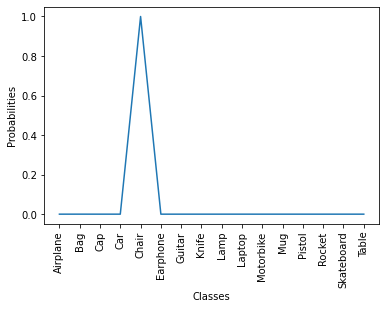

In [ ]:
# Three.js based visualizer
visualizer = JVisualizer()

# Basic inference and visualization loop
MAX_SAMPLES = 15
for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    visualizer.add_geometry(cloud)
    visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))
    